In [95]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [96]:
import numpy as np
import pandas as pd

In [97]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [98]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [99]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

#Everything in this cell and above provided courtesy of the starter code writer.

In [100]:
# reflect an existing database into a new model

Base = automap_base()


In [101]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [102]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [103]:
# Save references to each table

Measure = Base.classes.measurement

Station = Base.classes.station


In [104]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Climate Analysis

In [105]:
# Inspecting the first row

first_row = session.query(Measure).first()
first_row.__dict__




{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e4c9a71668>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [106]:
#A package to parse strings into datetimes

from dateutil.parser import parse

In [107]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

late_date = session.query(Measure.date).order_by(Measure.date.desc()).first()

#Get the string out of the result object
late_date_str = late_date[0]

# Converting the string in late_date to a datetime object
late_date_dt = parse(late_date_str)

#The date 1 year prior to the last day in the dataset 
early_date_dt = late_date_dt - dt.timedelta(days=365)

#Store the early date in a string for later
early_date_str = early_date_dt.strftime("%Y-%m-%d")



In [108]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measure.date, Measure.prcp).\
    filter(Measure.date > early_date_str).filter(Measure.date <= late_date_str).all()


In [109]:
connect = engine.connect()

In [110]:
# Save the query results as a Pandas DataFrame and set the index to the date column
results_df = pd.DataFrame(results, columns=['date','prcp'])

results_df.set_index('date', inplace=True, drop=True)

results_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


In [111]:
# Sort the dataframe by date
results_sorted_df = results_df.sort_values(by=['date'])
results_sorted_df


,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


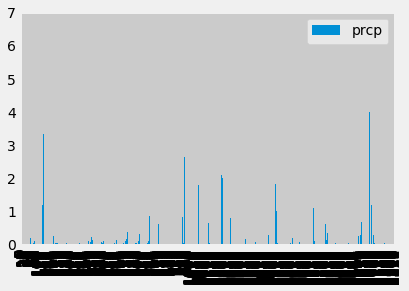

In [112]:
# Use Pandas Plotting with Matplotlib to plot the data


results_sorted_df.plot(kind="bar", use_index=False)


In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data

results_sorted_df['prcp'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [55]:
# Design a query to show how many stations are available in this dataset?

# I manually verified that all the stations in Station appear in Measure,
# so a join is not necessary at this step.

station_count = engine.execute('SELECT COUNT(DISTINCT station) FROM measurement').first()[0]

station_count



9

In [61]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_freq = engine.execute('SELECT station, COUNT(station) \
    FROM measurement GROUP BY station ORDER BY COUNT(station) DESC')





station_freq_df = pd.DataFrame(station_freq, columns=['station', 'frequency'])
station_freq_df

,station,frequency
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [74]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

active_station = station_freq_df.iloc[0,0]

low_temp = engine.execute('SELECT MIN(tobs) FROM measurement').first()[0]

hi_temp = engine.execute('SELECT MAX(tobs) FROM measurement').first()[0]

av_temp = engine.execute('SELECT AVG(tobs) FROM measurement').first()[0]

print(f"Low temp is {low_temp} degrees F.")
print(f"High temp is {hi_temp} degrees F.")
print(f"Average temp is {av_temp} degrees F.")

Low temp is 53.0 degrees F.
High temp is 87.0 degrees F.
Average temp is 73.09795396419437 degrees F.


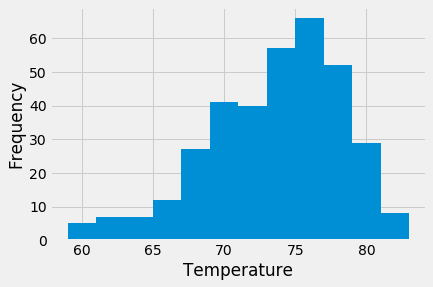

In [94]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_results = session.query(Measure.date, Measure.tobs).\
    filter(Measure.date > early_date_str).filter(Measure.date <= late_date_str). \
    filter(Measure.station == active_station).all()

temp_results_df = pd.DataFrame(temp_results, columns=['date', 'Temperature'])

temp_results_df = temp_results_df.sort_values(by=['date'])

temp_results_df

plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.hist(temp_results_df['Temperature'], bins=12)

plt.show()




## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measure.tobs), func.avg(Measure.tobs), func.max(Measure.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measure.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
